In [12]:
#Imports
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d, CubicSpline
from tqdm import tqdm
import warnings


%matplotlib inline

In [13]:
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"
spec_data_path = os.path.join(dataset_dir,"HETVIPS_LAMOST_SPEC")
spec_data = Table.read(spec_data_path)

In [14]:
spec_quality_mask = np.where((spec_data["FEH_ERR"] < 0.2) & (spec_data["classification"] == "STAR") & (spec_data["TEFF"] > 0) & ( 1 <= spec_data["LOGG"] ) & (spec_data["LOGG"] <= 5) & (spec_data["TEFF"] <= 25000) & (spec_data["SNR_G"] > 5) & (abs(spec_data["RV_2"]) < 600) & (spec_data["RV_ERR"] < 10)  )
quality_spec = spec_data[spec_quality_mask]
len(quality_spec)

1403

In [15]:
cut_data = []
cut_var = []
uncut_data = []
for i in range(len(quality_spec["spec"])):
    cut_data.append(quality_spec["spec"][i][50:-50])
    cut_var.append(quality_spec["spec_error"][i][50:-50])
    uncut_data.append(quality_spec["spec"][i])

cut_data = np.array(cut_data)
cut_var = np.array(cut_var)
uncut_data = np.array(uncut_data)

In [16]:
np.nanmedian(cut_var.flatten())

0.6046403576918522

In [17]:
#Sampling the spectra
import time
sampling_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)
sampled_spectras = [] #Stores the up, down or evenly sampled spectra
new_var = []
corrected = []

def sample_data(current_spectra_flux, var, sampling_timings=[], sampled_spectras=[]): #new_sample_size is the size you set to up, down or evenly sample

    start = time.perf_counter()

    with warnings.catch_warnings():
        warnings.filterwarnings("error")
        try:
            median_var = np.nanmedian(var)
        except:
            median_var = 0.6

    current_spectra_flux = np.array(current_spectra_flux)
    nan_mask = np.isnan(current_spectra_flux) #array of True False values of where the nan values are (True when nan value is present)
    nan_indices = np.flatnonzero(nan_mask) #gets indecies of all non zero elements (here all True elements in the mask) i.e all data that is nan
    non_nan_indices = np.flatnonzero(~nan_mask) #the ~ reverses the True False values. We now have indecies of all the data that is not nan
    current_spectra_flux[nan_indices] = np.interp(nan_indices,non_nan_indices,current_spectra_flux[non_nan_indices]) # NaN values removed

    var[nan_indices] = median_var * 25

    var_nan_mask = np.isnan(var)
    var_nan_indices = np.flatnonzero(var_nan_mask)
    var[var_nan_indices] = median_var * 25
    
    finish = time.perf_counter()
    
    new_var.append(var)
    sampling_timings.append(finish-start)
    sampled_spectras.append(current_spectra_flux)

for i,spec in enumerate(cut_data):
    sample_data(spec,cut_var[i],sampling_timings,sampled_spectras)

In [18]:
#Sampling the uncut spectra
uncut_sampled_spectras = [] #Stores the up, down or evenly sampled spectra

def sample_data(current_spectra_flux, uncut_sampled_spectras=[]): #new_sample_size is the size you set to up, down or evenly sample

    start = time.perf_counter()

    current_spectra_flux = np.array(current_spectra_flux)
    nan_mask = np.isnan(current_spectra_flux) #array of True False values of where the nan values are (True when nan value is present)
    nan_indices = np.flatnonzero(nan_mask) #gets indecies of all non zero elements (here all True elements in the mask) i.e all data that is nan
    non_nan_indices = np.flatnonzero(~nan_mask) #the ~ reverses the True False values. We now have indecies of all the data that is not nan
    current_spectra_flux[nan_indices] = np.interp(nan_indices,non_nan_indices,current_spectra_flux[non_nan_indices]) # NaN values removed

    uncut_sampled_spectras.append(current_spectra_flux)

for i,spec in enumerate(uncut_data):
    sample_data(spec,uncut_sampled_spectras)

In [19]:
#Implementing Boosted Median Continuum On Spectra
BMC_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)
normalized_spectra = [] #Stores the normalized spectra
continuums = [] #Stores the continuums of the spectra



def BMC(resampled_flux,uncut_spec,window_size=50,percentile=0.98,BMC_timings=[],normalized_spectra=[],continuums=[]):

    start = time.perf_counter()

    spec_len = len(resampled_flux) 
    half_window_size = window_size//2 #We do this because the window is centered around the current value being determined. i.e index 100 will consider indecies 51-150 as part of the window
    percentile_idx = int(percentile * window_size) #Since the 

    first_reflection = uncut_spec[:half_window_size]
    second_reflection = uncut_spec[-half_window_size:]
    extended_flux = np.concatenate([first_reflection,resampled_flux,second_reflection])
    
    running_stack = sorted(extended_flux[:window_size]) #Stars as a sorted list of the first 100 
    continuum = [] #Because the window doesn't move until the index == half_window_size, you're still taking the nth percentile of resampled_flux[:window_size]

    for i in range(half_window_size, spec_len + half_window_size):
        #remove operation
        removal_val = extended_flux[i-half_window_size]
        removal_idx = np.searchsorted(running_stack,removal_val) #Binary search to remove i-half_window_size value as the window has moved forward by 1
        del running_stack[removal_idx]

        #insert operation
        insertion_val = extended_flux[i+half_window_size]
        insertion_idx = np.searchsorted(running_stack,insertion_val) #Binary search to insert the value into the running stack which is always sorted
        running_stack.insert(insertion_idx,insertion_val)

        continuum_val = running_stack[percentile_idx] 
        continuum.append(continuum_val) 

    continuum = np.array(continuum)
    normalized = resampled_flux/continuum

    finish = time.perf_counter()
    
    BMC_timings.append(finish-start)
    normalized_spectra.append(normalized)
    continuums.append(continuum)

counter = 0
for resampled_flux in tqdm(sampled_spectras):
    uncut_spec = uncut_sampled_spectras[counter]
    BMC(resampled_flux,uncut_spec,50,0.98,BMC_timings,normalized_spectra,continuums)
    counter += 1

100%|██████████| 1403/1403 [00:14<00:00, 95.94it/s] 


In [8]:

#Implementing Boosted Median Continuum On Spectra
BMC_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)
normalized_spectra = [] #Stores the normalized spectra
continuums = [] #Stores the continuums of the spectra



def BMC(resampled_flux,window_size=50,percentile=0.98,BMC_timings=[],normalized_spectra=[],continuums=[]):

    start = time.perf_counter()

    spec_len = len(resampled_flux) 
    half_window_size = window_size//2 #We do this because the window is centered around the current value being determined. i.e index 100 will consider indecies 51-150 as part of the window
    running_stack = sorted(resampled_flux[:window_size]) #Stars as a sorted list of the first 100 
    percentile_idx = int(percentile * window_size) #Since the 
    continuum = [running_stack[percentile_idx]] * half_window_size #Because the window doesn't move until the index == half_window_size, you're still taking the nth percentile of resampled_flux[:window_size]

    for i in range(half_window_size, spec_len-half_window_size):

        #remove operation
        removal_val = resampled_flux[i-half_window_size]
        removal_idx = np.searchsorted(running_stack,removal_val) #Binary search to remove i-half_window_size value as the window has moved forward by 1
        del running_stack[removal_idx]

        #insert operation
        insertion_val = resampled_flux[i+half_window_size]
        insertion_idx = np.searchsorted(running_stack,insertion_val) #Binary search to insert the value into the running stack which is always sorted
        running_stack.insert(insertion_idx,insertion_val)

        continuum_val = running_stack[percentile_idx] 
        continuum.append(continuum_val) 

    continuum += [running_stack[percentile_idx]] * half_window_size #Window remains stationary for the last half_window_size values so we append the same value
    continuum = np.array(continuum)
    normalized = resampled_flux/continuum

    finish = time.perf_counter()
    
    BMC_timings.append(finish-start)
    normalized_spectra.append(normalized)
    continuums.append(continuum)

for resampled_flux in tqdm(sampled_spectras):
    BMC(resampled_flux,100,0.98,BMC_timings,normalized_spectra,continuums)


100%|██████████| 1403/1403 [00:15<00:00, 88.31it/s]


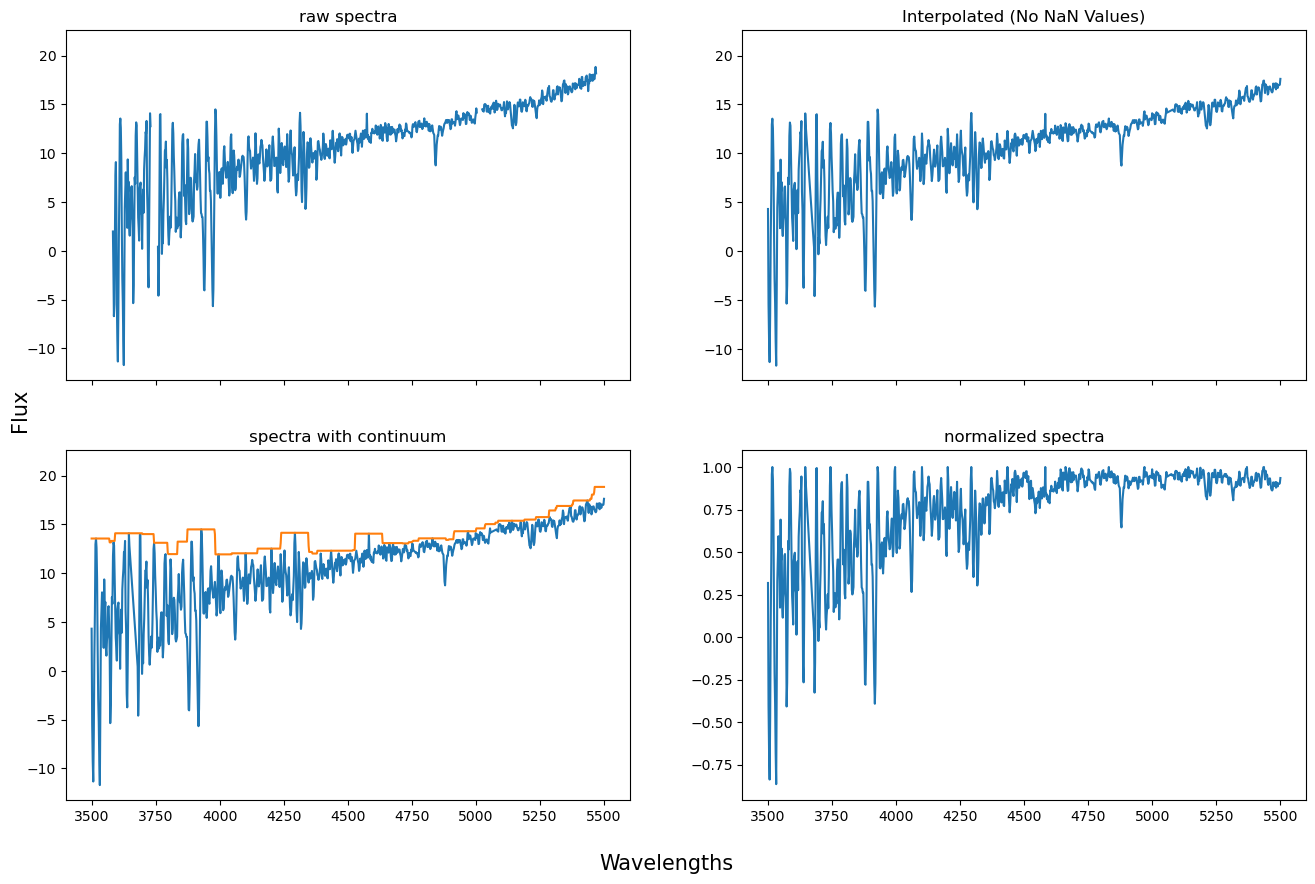

In [20]:
#Plotting graphs
idx = 7 #change this to the idx of the spectra you want to see
continuum = continuums[idx]
normalized = normalized_spectra[idx]
resampled_flux = sampled_spectras[idx]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16, 10),sharex=True)

ax1.plot(np.linspace(3500,5500,1036),quality_spec["spec"][idx])
ax1.set_ylim(top=max(resampled_flux)+5)
ax1.set_title("raw spectra")

ax2.plot(np.linspace(3500,5500,len(resampled_flux)),resampled_flux)
ax2.set_ylim(top=max(resampled_flux)+5)
ax2.set_title("Interpolated (No NaN Values)")

ax3.plot(np.linspace(3500,5500,len(resampled_flux)),resampled_flux)
ax3.plot(np.linspace(3500,5500,len(continuum)),continuum)
ax3.set_ylim(top=max(resampled_flux)+5)
ax3.set_title("spectra with continuum")

ax4.plot(np.linspace(3500,5500,len(normalized)),normalized)
ax4.set_ylim(top=max(normalized)+0.1)
ax4.set_title("normalized spectra")
fig.text(0.5, 0.04, 'Wavelengths', ha='center',size=15)
fig.text(0.09, 0.5, 'Flux', va='center', rotation='vertical',size=15)
plt.show()


In [21]:
#Appending the new data to the old fits file data
quality_spec.add_column(normalized_spectra,name="spec_norm")
quality_spec.add_column(continuums,name="spec_continuums")
quality_spec.add_column(sampled_spectras,name="spec_sampled")
quality_spec.add_column(new_var,name="updated_var")

In [22]:
#Saving the modified file
from astropy.io import fits
modified_data_path = os.path.join(dataset_dir,"HETVIPS_LAMOST_SPEC_UPDATED.fits")
hdu = fits.BinTableHDU(quality_spec)
hdu.writeto(modified_data_path,overwrite=True)